# This is where the content models are trained and evaluated

In [15]:
# https://apple.github.io/turicreate/docs/userguide/recommender/choosing-a-model.html
# https://apple.github.io/turicreate/docs/api/generated/turicreate.recommender.item_content_recommender.create.html#turicreate.recommender.item_content_recommender.create
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# if you don't already have it
# !pip install turicreate

In [4]:
# data science libraries
import pandas as pd
import numpy as np
import turicreate as tc
from turicreate.toolkits.recommender.util import precision_recall_by_user
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [5]:
# loading and saving models
# because sometimes notebooks die
import pickle
from glob import glob
from os import path
from tqdm.notebook import tqdm

In [6]:
# data
raw_actions = tc.SFrame.read_csv('../data/raw_data/ratings.csv', verbose=False)
raw_tags = tc.SFrame.read_csv('../data/raw_data/tags.csv', verbose=False)
raw_books_with_tags = tc.SFrame.read_csv('../data/raw_data/book_tags.csv', verbose=False)
books = tc.SFrame.read_csv('../data/parsed_data/ultimate_books.csv', verbose=False)
to_read = tc.SFrame.read_csv('../data/raw_data/to_read.csv', verbose=False)
books_with_tags = tc.SFrame.read_csv('../data/parsed_data/books_with_tags.csv', verbose=False)
clustered_books_with_tags = tc.SFrame.read_csv('../data/parsed_data/clustered_books_with_tags.csv', verbose=False)
genre_tags = tc.SFrame.read_csv('../data/parsed_data/genre_tag_clusters.csv', verbose=False)
book_genre_clusters = tc.SFrame.read_csv('../data/parsed_data/books_with_genre_clusters.csv', verbose=False)

2

In [8]:
# remove actions from filtered books
actions = raw_actions.join(books)[['user_id','book_id','rating']]

In [9]:
# train and test data split by user
to_read_train, to_read_test = tc.recommender.util.random_split_by_user(to_read, user_id='user_id', item_id='book_id')

In [10]:
# Count Vectorizer on tags
cv = CountVectorizer()
cv.fit(books_with_tags['tag_name'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [11]:
# Tags -> CountVectorizer -> TruncatedSVD -> 35 features
cv_svd = TruncatedSVD(n_components=35)
X = cv_svd.fit_transform(cv.transform(books_with_tags['tag_name']))
print(cv_svd.explained_variance_ratio_.sum())
svd_tags = tc.SFrame(pd.DataFrame(X))
svd_tags['book_id'] = books['book_id']

0.6874550163042866


In [12]:
# Tags -> tf-idf -> TruncatedSVD -> 35 features
tfid = TfidfVectorizer()
tfid.fit(books_with_tags['tag_name'])
tfid_svd = TruncatedSVD(n_components=35)
X = tfid_svd.fit_transform(tfid.transform(books_with_tags['tag_name']))
tfid_svd.explained_variance_ratio_.sum()
svd_tfid_tags = tc.SFrame(pd.DataFrame(X))
svd_tfid_tags['book_id'] = books['book_id']

In [13]:
# combinations of side_data, model, latent factors, similarity types
side_data = [{'name': 'none', 'value': None}, 
              {'name': 'cluster_id', 'value':clustered_books_with_tags[['book_id','cluster']]},
              {'name': 'countVect->SVD', 'value':svd_tags},
              {'name': 'tfid->SVD', 'value':svd_tfid_tags},
              {'name': 'tag_clusters', 'value':book_genre_clusters}]

models = [{'name': 'content', 'value': tc.recommender.item_content_recommender}]              
num_factors_options = [4, 8, 12]
similarity_types = ['jaccard','cosine','pearson']


In [ ]:
trained_models = []
for model in models:
    for item_data in side_data:
        if model['name'] == 'content':
            # Content model must have item data
            if item_data['name'] != 'none':
                label = f"{model['name']} {item_data['name']}"
                print(label)
                test_model = model['value'].create(item_data['value'], 
                                          user_id='user_id', 
                                          item_id='book_id',
                                          observation_data=train_data,
                                          target='rating',
                                          verbose=False)
                
                trained_models.append({'name': label, 'model': test_model})
        
        elif model['name'] == 'factorization' or model['name'] == 'ranking_factorization':
            # ranking factorization doesn't converge when using tag clusters. Needs more memory
            # factorization has a latent factors param instead of a similarity type
            if model['name'] != 'ranking_factorization' and item_data['name'] != 'tag_clusters':
                for factors_option in num_factors_options:
                    label = f"{model['name']} {item_data['name']} {factors_option}"
                    print(label)
                    test_model = model['value'].create(train_data, 
                                          user_id='user_id', 
                                          item_id='book_id',
                                          target='rating',
                                          item_data=item_data['value'],
                                          num_factors=factors_option,
                                          verbose=False)
                    
                    trained_models.append({'name': label, 'model': test_model,})
        else:
            # item similarity has a similarity type instead of a latent factors param
            for similarity_type in similarity_types:
                label = f"{model['name']} {item_data['name']} {similarity_type}"
                print(label)
                test_model = model['value'].create(train_data, 
                                      user_id='user_id', 
                                      item_id='book_id',
                                      target='rating',
                                      item_data=item_data['value'],
                                      similarity_type=similarity_type,
                                      verbose=False)
                
                trained_models.append({'name': label,'model': test_model})

In [20]:
content_model_path = '../models/content_models'

In [20]:
# save models in case notebook crashes

def save_models(models, model_path):
    for e in models:
        file_name = e['name'].replace('-','').replace(' ','-')
        e['model'].save(path.join(model_path, file_name)


save_models(trained_models, content_model_path)
    

In [24]:
# load saved models, after notebook crashes
def load_model_dir(models_path, name_prefix=''):
    model_archives = glob(path.join(models_path,'*'))
    return [{'name': f'{name_prefix}{path.basename(model_path)}', 'model': tc.load_model(model_path)} for model_path in model_archives]

trained_models = load_model_dir(content_model_path)

In [25]:
# run evaluation metrics on each model using test data
def evaluate_models(models):
    for model_obj in tqdm(models):
        model_obj['eval'] = model_obj['model'].evaluate(test_data, exclude_known_for_precision_recall=True, verbose=False)
    return models

In [26]:
evaluated_models = evaluate_models(trained_models)

In [27]:
# Get RMSE metrics from evaluated models

def make_precision_series(eval_array):
    x = [e['name'] for e in eval_array]
    y0 = [e['eval']['precision_recall_overall'][0]['precision'] for e in eval_array]
    y1 = [e['eval']['precision_recall_overall'][4]['precision'] for e in eval_array]
    y2 = [e['eval']['precision_recall_overall'][9]['precision'] for e in eval_array]
    return x, [y0,y1,y2]

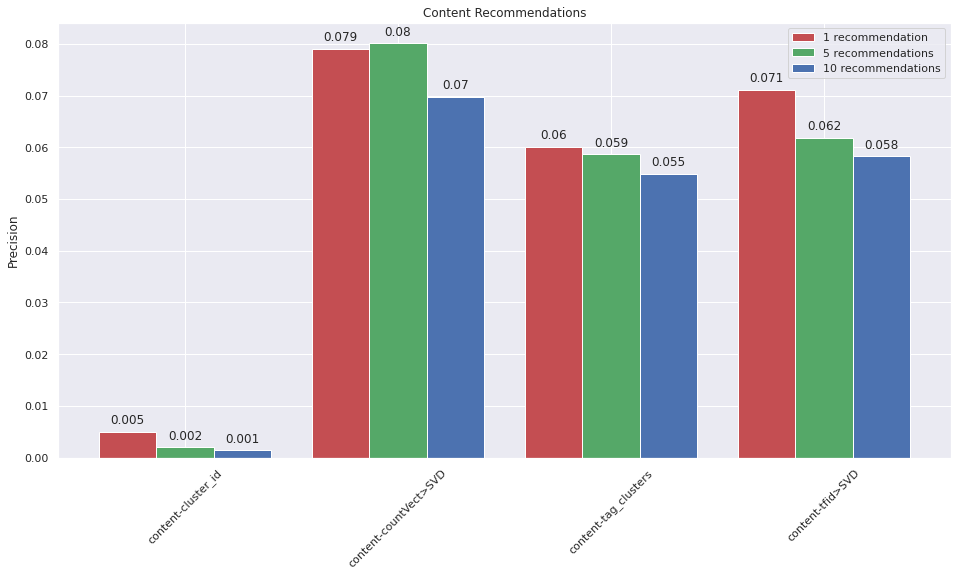

In [28]:
# Content
x, ys = make_precision_series(sorted(evaluated_models, key=lambda x: x['name']))


ind = np.arange(len(ys[0]))  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

yvals = ys[0]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = ys[1]
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = ys[2]
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Precision')
ax.set_xticks(ind+width)
ax.set_xticklabels( x , rotation=45)
ax.legend( (rects1[0], rects2[0], rects3[0]), ('1 recommendation', '5 recommendations', '10 recommendations') )

def autolabel(rects, yvals):
    for rect_index, rect in enumerate(rects):
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h+0.001, round(yvals[rect_index],3),
                ha='center', va='bottom')

autolabel(rects1, ys[0])
autolabel(rects2, ys[1])
autolabel(rects3, ys[2])

plt.title('Content Recommendations')

plt.show()

In [29]:
x

['content-cluster_id',
 'content-countVect>SVD',
 'content-tag_clusters',
 'content-tfid>SVD']

In [30]:
ys[1]

[0.002002002002002001,
 0.08008008008008013,
 0.05865865865865869,
 0.061861861861861864]